# 5 Azure Maps Visualization and Rendering

https://azure.microsoft.com/en-us/products/azure-maps/?msockid=2e39c66c693c66a5151fd200687567d0

https://learn.microsoft.com/en-us/azure/azure-maps/

In [1]:
import base64
import datetime
import folium
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import random
import requests
import sys

from dotenv import load_dotenv
from folium.plugins import HeatMap
from io import BytesIO
from IPython.display import IFrame, FileLink
from urllib.parse import urlencode
from PIL import Image
from typing import List, Dict, Tuple, Optional

## Settings

In [2]:
sys.version

'3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]'

In [3]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 01-Sep-2025 08:02:48


In [4]:
RESULTS_DIR = "results"

os.makedirs(RESULTS_DIR, exist_ok=True)

In [5]:
load_dotenv("azure.env")

True

In [6]:
class AzureMapsClient:
    """
    Azure Maps API Client for Python
    """
    
    def __init__(self, subscription_key: str):
        """
        Initialize Azure Maps client
        
        Args:
            subscription_key: Your Azure Maps subscription key
        """
        self.subscription_key = subscription_key
        self.base_url = "https://atlas.microsoft.com"
        
    def _make_request(self, endpoint: str, params: Dict) -> Dict:
        """
        Make authenticated request to Azure Maps API
        
        Args:
            endpoint: API endpoint
            params: Request parameters
            
        Returns:
            API response as dictionary
        """
        params['api-version'] = '1.0'
        params['subscription-key'] = self.subscription_key
        
        url = f"{self.base_url}/{endpoint}"
        
        try:
            response = requests.get(url, params=params)
            response.raise_for_status()
            return response.json()
        except requests.exceptions.RequestException as e:
            print(f"API request failed: {e}")
            return {}


In [7]:
azure_maps = AzureMapsClient(os.getenv('AZURE_MAPS_KEY'))

## Helper

In [8]:
class VisualizationDemo:
    """
    Demonstrates Azure Maps visualization capabilities
    """
    
    def __init__(self, azure_maps_client):
        self.client = azure_maps_client
        self.render_base_url = "https://atlas.microsoft.com/map/static/png"
    
    def create_heatmap_data(self, points: List[Tuple[float, float, float]]) -> folium.Map:
        """
        Create heatmap visualization
        
        Args:
            points: List of (lat, lon, intensity) tuples
            
        Returns:
            Folium map with heatmap
        """
        if not points:
            return None
            
        # Calculate center
        center_lat = sum(point[0] for point in points) / len(points)
        center_lon = sum(point[1] for point in points) / len(points)
        
        # Create map
        m = folium.Map(
            location=[center_lat, center_lon],
            zoom_start=10,
            tiles='OpenStreetMap'
        )
        
        # Add heatmap
        HeatMap(points, radius=15, blur=10, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}).add_to(m)
        
        return m
    

## Examples

In [9]:
viz = VisualizationDemo(azure_maps)

### Example 1: Static Map Generation

In [10]:
# Paris center (lat, lon)
paris = (48.8566, 2.3522)

# Base URL for Azure Static Maps
base_url = "https://atlas.microsoft.com/map/static/png"

# Build query parameters
params = {
    "subscription-key": os.getenv('AZURE_MAPS_KEY'),  # Make sure this variable is defined
    "api-version": "1.0",
    "center": f"{paris[1]},{paris[0]}",  # lon,lat order for center (comma-separated)
    "zoom": 11,
    "width": 800,
    "height": 600
}

# Encode URL
url = f"{base_url}?{urlencode(params)}"

# Download the map image with error handling
try:
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for bad status codes
    
    output_file = os.path.join(RESULTS_DIR, "paris_map.png")  # Make sure RESULTS_DIR is defined
    with open(output_file, "wb") as f:
        f.write(response.content)
    print(f"Map saved as {output_file}")
    
except requests.exceptions.RequestException as e:
    print(f"Error fetching map: {e}")
except Exception as e:
    print(f"Error saving file: {e}")

Map saved as results/paris_map.png


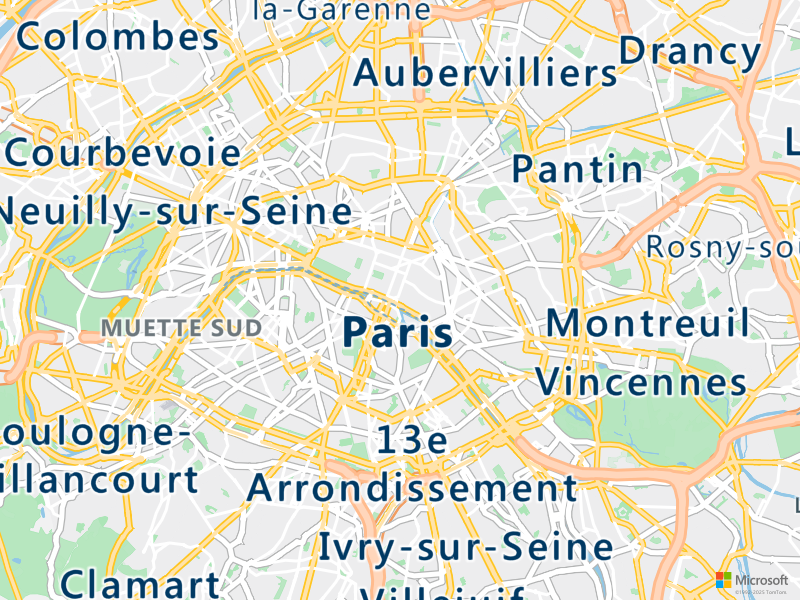

In [11]:
img = Image.open(output_file)
img

In [12]:
seattle = ( 47.6062, -122.3321)

# Base URL for Azure Static Maps
base_url = "https://atlas.microsoft.com/map/static/png"

# Build query parameters
params = {
    "subscription-key": os.getenv('AZURE_MAPS_KEY'),  # Make sure this variable is defined
    "api-version": "1.0",
    "center": f"{seattle[1]},{seattle[0]}",  # lon,lat order for center (comma-separated)
    "zoom": 11,
    "width": 800,
    "height": 600
}

# Encode URL
url = f"{base_url}?{urlencode(params)}"

# Download the map image with error handling
try:
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for bad status codes
    
    output_file = os.path.join(RESULTS_DIR, "seattle_map.png")  # Make sure RESULTS_DIR is defined
    with open(output_file, "wb") as f:
        f.write(response.content)
    print(f"Map saved as {output_file}")
    
except requests.exceptions.RequestException as e:
    print(f"Error fetching map: {e}")
except Exception as e:
    print(f"Error saving file: {e}")

Map saved as results/seattle_map.png


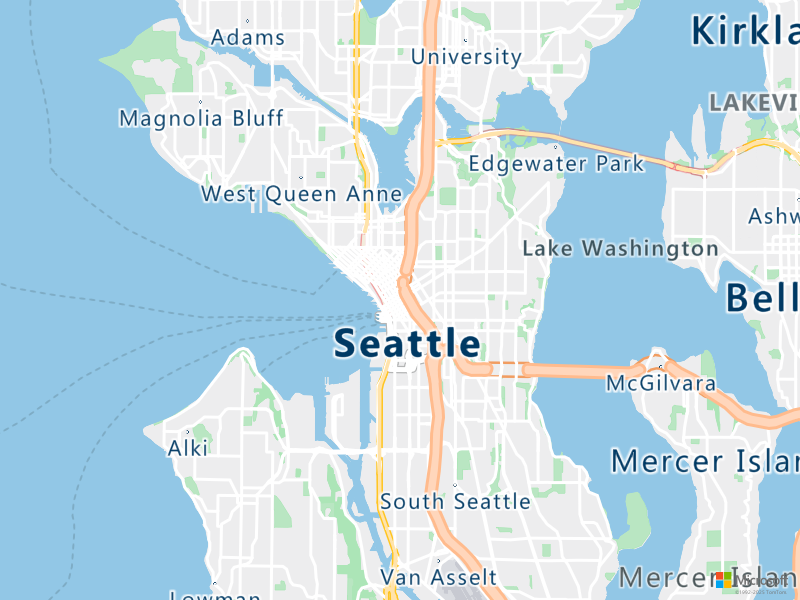

In [13]:
img = Image.open(output_file)
img

### Example 2: Interactive Map with Custom Layers

In [14]:
def create_multi_layer_map(center_coords: Tuple[float, float]) -> folium.Map:
    """Create interactive map with multiple layers"""
    
    m = folium.Map(
        location=center_coords,
        zoom_start=12,
        tiles='OpenStreetMap'
    )
    
    # Add different tile layers with proper attributions
    folium.TileLayer(
        tiles='https://stamen-tiles-{s}.a.ssl.fastly.net/terrain/{z}/{x}/{y}.png',
        attr='Map tiles by <a href="http://stamen.com">Stamen Design</a>, under <a href="http://creativecommons.org/licenses/by/3.0">CC BY 3.0</a>. Data by <a href="http://openstreetmap.org">OpenStreetMap</a>, under <a href="http://www.openstreetmap.org/copyright">ODbL</a>.',
        name='Stamen Terrain',
        overlay=False,
        control=True
    ).add_to(m)
    
    folium.TileLayer(
        tiles='https://stamen-tiles-{s}.a.ssl.fastly.net/toner/{z}/{x}/{y}.png',
        attr='Map tiles by <a href="http://stamen.com">Stamen Design</a>, under <a href="http://creativecommons.org/licenses/by/3.0">CC BY 3.0</a>. Data by <a href="http://openstreetmap.org">OpenStreetMap</a>, under <a href="http://www.openstreetmap.org/copyright">ODbL</a>.',
        name='Stamen Toner',
        overlay=False,
        control=True
    ).add_to(m)
    
    folium.TileLayer(
        tiles='https://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}{r}.png',
        attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
        name='CartoDB Positron',
        overlay=False,
        control=True
    ).add_to(m)
    
    folium.TileLayer(
        tiles='https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}{r}.png',
        attr='&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',
        name='CartoDB Dark Matter',
        overlay=False,
        control=True
    ).add_to(m)
    
    # Add satellite imagery
    folium.TileLayer(
        tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community',
        name='Esri Satellite',
        overlay=False,
        control=True
    ).add_to(m)
    
    # Add layer control
    folium.LayerControl().add_to(m)
    
    return m

# Create multi-layer map of New York
nyc_coords = (40.7128, -74.0060)
multi_layer_map = create_multi_layer_map(nyc_coords)

# Add some markers
folium.Marker(
    location=[40.7589, -73.9851],  # Times Square
    popup="Times Square",
    icon=folium.Icon(color='red', icon='star')
).add_to(multi_layer_map)

folium.Marker(
    location=[40.7505, -73.9934],  # Empire State Building
    popup="Empire State Building", 
    icon=folium.Icon(color='pink', icon='building')
).add_to(multi_layer_map)

# Save the map
output_file = os.path.join(RESULTS_DIR, "nyc_multi_layer_map.html")
multi_layer_map.save(output_file)
print(f"✅ Map saved as {output_file}")

✅ Map saved as results/nyc_multi_layer_map.html


In [15]:
IFrame(src=output_file, width=1024, height=860)

In [16]:
map_link = FileLink(path=output_file)
map_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow8/code/Users/seretkow/azure maps/results/nyc_multi_layer_map.html

### Example 3: Heatmap Visualization

In [17]:
# Generate sample data (simulating crime incidents in a city)
def generate_sample_heatmap_data(center: Tuple[float, float], num_points: int = 100) -> List[Tuple[float, float, float]]:
    """Generate sample data for heatmap"""
    lat_center, lon_center = center
    data_points = []
    
    # Create clusters of incidents
    cluster_centers = [
        (lat_center + 0.01, lon_center - 0.01),  # Downtown cluster
        (lat_center - 0.02, lon_center + 0.02),  # Suburban cluster
        (lat_center + 0.03, lon_center + 0.01),  # Industrial cluster
    ]
    
    for _ in range(num_points):
        # Choose a cluster
        cluster_lat, cluster_lon = random.choice(cluster_centers)
        
        # Add random offset around cluster center
        lat = cluster_lat + random.gauss(0, 0.005)
        lon = cluster_lon + random.gauss(0, 0.005)
        intensity = random.uniform(0.3, 1.0)
        
        data_points.append((lat, lon, intensity))
    
    return data_points

# Generate sample incident data for Seattle
seattle_coords = (47.6062, -122.3321)
heatmap_data = generate_sample_heatmap_data(seattle_coords, 150)

print(f"Generated {len(heatmap_data)} sample data points for heatmap...")

# Create heatmap
heatmap = viz.create_heatmap_data(heatmap_data)
if heatmap:
    output_file = os.path.join(RESULTS_DIR, "seattle_heatmap.html")
    heatmap.save(output_file)
    print(f"✅ Map saved as {output_file}")

Generated 150 sample data points for heatmap...
✅ Map saved as results/seattle_heatmap.html


In [18]:
IFrame(src=output_file, width=860, height=640)

In [19]:
map_link = FileLink(path=output_file)
map_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow8/code/Users/seretkow/azure maps/results/seattle_heatmap.html

### Example 4: Data Visualization with Charts

Heatmap Data Analysis:
  Total Points: 150
  Avg Intensity: 0.658
  Max Intensity: 0.999
  Min Intensity: 0.307
  High Intensity Count: 69


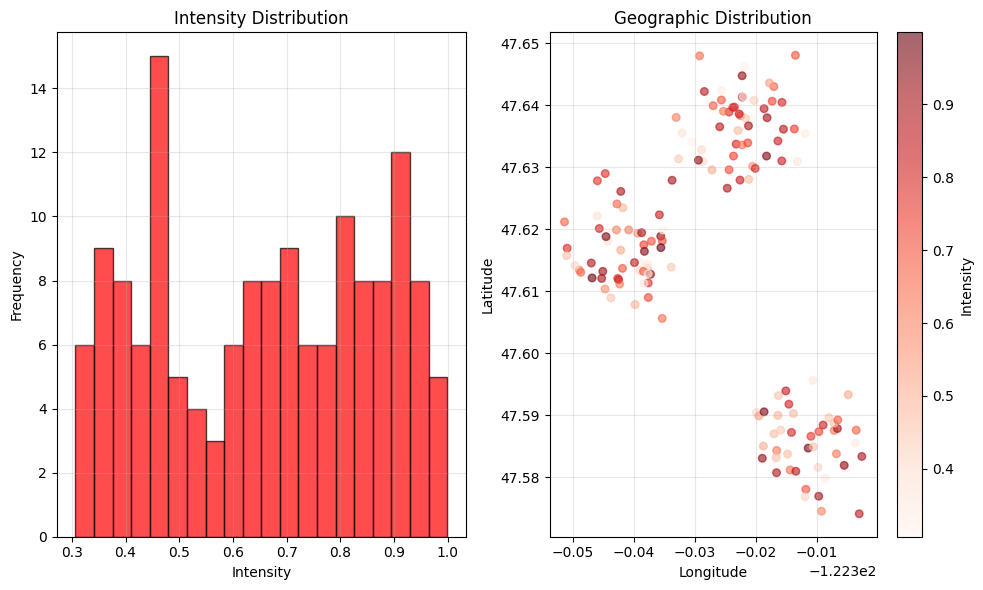

In [20]:
# Analyze the heatmap data
def analyze_heatmap_data(data_points: List[Tuple[float, float, float]]) -> Dict:
    """Analyze heatmap data for statistics"""
    if not data_points:
        return {}
    
    intensities = [point[2] for point in data_points]
    
    return {
        'total_points': len(data_points),
        'avg_intensity': sum(intensities) / len(intensities),
        'max_intensity': max(intensities),
        'min_intensity': min(intensities),
        'high_intensity_count': len([i for i in intensities if i > 0.7])
    }

# Analyze data
analysis = analyze_heatmap_data(heatmap_data)

print("Heatmap Data Analysis:")
for key, value in analysis.items():
    if isinstance(value, float):
        print(f"  {key.replace('_', ' ').title()}: {value:.3f}")
    else:
        print(f"  {key.replace('_', ' ').title()}: {value}")

# Create intensity distribution chart
plt.figure(figsize=(10, 6))

# Plot 1: Intensity histogram
plt.subplot(1, 2, 1)
intensities = [point[2] for point in heatmap_data]
plt.hist(intensities, bins=20, alpha=0.7, color='red', edgecolor='black')
plt.title('Intensity Distribution')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Plot 2: Geographic scatter plot
plt.subplot(1, 2, 2)
lats = [point[0] for point in heatmap_data]
lons = [point[1] for point in heatmap_data]
intensities = [point[2] for point in heatmap_data]

scatter = plt.scatter(lons, lats, c=intensities, cmap='Reds', alpha=0.6, s=30)
plt.colorbar(scatter, label='Intensity')
plt.title('Geographic Distribution')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'heatmap_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

### Example 5: Custom Map Styling

In [21]:
def create_custom_styled_map(center: Tuple[float, float], data_points: List[Dict]) -> folium.Map:
    """Create map with custom styling and multiple marker types"""
    
    m = folium.Map(
        location=center,
        zoom_start=12,
        tiles="CartoDB positron"
    )
    
    # Color scheme for different categories
    color_scheme = {
        'restaurant': {'color': 'red', 'icon': 'cutlery'},
        'hotel': {'color': 'blue', 'icon': 'bed'},
        'attraction': {'color': 'green', 'icon': 'star'},
        'transport': {'color': 'purple', 'icon': 'bus'},
        'shopping': {'color': 'orange', 'icon': 'shopping-cart'}
    }
    
    # Add markers with different styles
    for point in data_points:
        category = point.get('category', 'attraction')
        style = color_scheme.get(category, color_scheme['attraction'])
        
        # Create custom popup with HTML
        popup_html = f"""
        <div style="font-family: Arial; width: 200px;">
            <h4 style="color: {style['color']}; margin-bottom: 5px;">{point['name']}</h4>
            <p><strong>Category:</strong> {category.title()}</p>
            <p><strong>Rating:</strong> {'⭐' * point.get('rating', 3)}</p>
            <p><strong>Address:</strong> {point.get('address', 'N/A')}</p>
        </div>
        """
        
        folium.Marker(
            location=[point['lat'], point['lon']],
            popup=folium.Popup(popup_html, max_width=250),
            tooltip=point['name'],
            icon=folium.Icon(color=style['color'], icon=style['icon'])
        ).add_to(m)
    
    return m

# Sample data for custom styled map
london_coords = (51.5074, -0.1278)
london_pois = [
    {'name': 'The Shard', 'lat': 51.5045, 'lon': -0.0865, 'category': 'attraction', 'rating': 5, 'address': '32 London Bridge St'},
    {'name': 'Harrods', 'lat': 51.4994, 'lon': -0.1630, 'category': 'shopping', 'rating': 4, 'address': '87-135 Brompton Rd'},
    {'name': 'The Ritz London', 'lat': 51.5074, 'lon': -0.1419, 'category': 'hotel', 'rating': 5, 'address': '150 Piccadilly'},
    {'name': 'Dishoom', 'lat': 51.5144, 'lon': -0.1419, 'category': 'restaurant', 'rating': 4, 'address': '12 Upper St Martin\'s Ln'},
    {'name': 'King\'s Cross Station', 'lat': 51.5308, 'lon': -0.1238, 'category': 'transport', 'rating': 3, 'address': 'Euston Rd'},
]

print("Creating custom styled map of London attractions...")
london_styled_map = create_custom_styled_map(london_coords, london_pois)

# Add custom legend
legend_html = '''
<div style="position: fixed; 
            top: 10px; right: 10px; width: 150px; height: 180px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:14px; padding: 10px;">
<h4>Legend</h4>
<p><i class="fa fa-cutlery" style="color:red"></i> Restaurant</p>
<p><i class="fa fa-bed" style="color:blue"></i> Hotel</p>
<p><i class="fa fa-star" style="color:green"></i> Attraction</p>
<p><i class="fa fa-bus" style="color:purple"></i> Transport</p>
<p><i class="fa fa-shopping-cart" style="color:orange"></i> Shopping</p>
</div>
'''

output_file = os.path.join(RESULTS_DIR, "london_custom_styled_map.html")
london_styled_map.save(output_file)
print(f"✅ Map saved as {output_file}")

Creating custom styled map of London attractions...
✅ Map saved as results/london_custom_styled_map.html


In [22]:
IFrame(src=output_file, width=860, height=640)

In [23]:
map_link = FileLink(path=output_file)
map_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow8/code/Users/seretkow/azure maps/results/london_custom_styled_map.html

#### Using OpenStreetMap

In [24]:
def create_custom_styled_map(center: Tuple[float, float], data_points: List[Dict]) -> folium.Map:
    """Create map with custom styling and multiple marker types"""
    
    m = folium.Map(
        location=center,
        zoom_start=12,
        tiles="OpenStreetMap"
    )
    
    # Color scheme for different categories
    color_scheme = {
        'restaurant': {'color': 'red', 'icon': 'cutlery'},
        'hotel': {'color': 'blue', 'icon': 'bed'},
        'attraction': {'color': 'green', 'icon': 'star'},
        'transport': {'color': 'purple', 'icon': 'bus'},
        'shopping': {'color': 'orange', 'icon': 'shopping-cart'}
    }
    
    # Add markers with different styles
    for point in data_points:
        category = point.get('category', 'attraction')
        style = color_scheme.get(category, color_scheme['attraction'])
        
        # Create custom popup with HTML
        popup_html = f"""
        <div style="font-family: Arial; width: 200px;">
            <h4 style="color: {style['color']}; margin-bottom: 5px;">{point['name']}</h4>
            <p><strong>Category:</strong> {category.title()}</p>
            <p><strong>Rating:</strong> {'⭐' * point.get('rating', 3)}</p>
            <p><strong>Address:</strong> {point.get('address', 'N/A')}</p>
        </div>
        """
        
        folium.Marker(
            location=[point['lat'], point['lon']],
            popup=folium.Popup(popup_html, max_width=250),
            tooltip=point['name'],
            icon=folium.Icon(color=style['color'], icon=style['icon'])
        ).add_to(m)
    
    return m

# Sample data for custom styled map
london_coords = (51.5074, -0.1278)
london_pois = [
    {'name': 'The Shard', 'lat': 51.5045, 'lon': -0.0865, 'category': 'attraction', 'rating': 5, 'address': '32 London Bridge St'},
    {'name': 'Harrods', 'lat': 51.4994, 'lon': -0.1630, 'category': 'shopping', 'rating': 4, 'address': '87-135 Brompton Rd'},
    {'name': 'The Ritz London', 'lat': 51.5074, 'lon': -0.1419, 'category': 'hotel', 'rating': 5, 'address': '150 Piccadilly'},
    {'name': 'Dishoom', 'lat': 51.5144, 'lon': -0.1419, 'category': 'restaurant', 'rating': 4, 'address': '12 Upper St Martin\'s Ln'},
    {'name': 'King\'s Cross Station', 'lat': 51.5308, 'lon': -0.1238, 'category': 'transport', 'rating': 3, 'address': 'Euston Rd'},
]

print("Creating custom styled map of London attractions...")
london_styled_map = create_custom_styled_map(london_coords, london_pois)

# Add custom legend
legend_html = '''
<div style="position: fixed; 
            top: 10px; right: 10px; width: 150px; height: 180px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:14px; padding: 10px;">
<h4>Legend</h4>
<p><i class="fa fa-cutlery" style="color:red"></i> Restaurant</p>
<p><i class="fa fa-bed" style="color:blue"></i> Hotel</p>
<p><i class="fa fa-star" style="color:green"></i> Attraction</p>
<p><i class="fa fa-bus" style="color:purple"></i> Transport</p>
<p><i class="fa fa-shopping-cart" style="color:orange"></i> Shopping</p>
</div>
'''

output_file = os.path.join(RESULTS_DIR, "london_custom_styled_map2.html")
london_styled_map.save(output_file)
print(f"✅ Map saved as {output_file}")

Creating custom styled map of London attractions...
✅ Map saved as results/london_custom_styled_map2.html


In [25]:
IFrame(src=output_file, width=860, height=640)

In [26]:
map_link = FileLink(path=output_file)
map_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow8/code/Users/seretkow/azure maps/results/london_custom_styled_map2.html

#### Using CartoDB dark_matter

In [27]:
def create_custom_styled_map(center: Tuple[float, float], data_points: List[Dict]) -> folium.Map:
    """Create map with custom styling and multiple marker types"""
    
    m = folium.Map(
        location=center,
        zoom_start=12,
        tiles="CartoDB dark_matter"
    )
    
    # Color scheme for different categories
    color_scheme = {
        'restaurant': {'color': 'red', 'icon': 'cutlery'},
        'hotel': {'color': 'blue', 'icon': 'bed'},
        'attraction': {'color': 'green', 'icon': 'star'},
        'transport': {'color': 'purple', 'icon': 'bus'},
        'shopping': {'color': 'orange', 'icon': 'shopping-cart'}
    }
    
    # Add markers with different styles
    for point in data_points:
        category = point.get('category', 'attraction')
        style = color_scheme.get(category, color_scheme['attraction'])
        
        # Create custom popup with HTML
        popup_html = f"""
        <div style="font-family: Arial; width: 200px;">
            <h4 style="color: {style['color']}; margin-bottom: 5px;">{point['name']}</h4>
            <p><strong>Category:</strong> {category.title()}</p>
            <p><strong>Rating:</strong> {'⭐' * point.get('rating', 3)}</p>
            <p><strong>Address:</strong> {point.get('address', 'N/A')}</p>
        </div>
        """
        
        folium.Marker(
            location=[point['lat'], point['lon']],
            popup=folium.Popup(popup_html, max_width=250),
            tooltip=point['name'],
            icon=folium.Icon(color=style['color'], icon=style['icon'])
        ).add_to(m)
    
    return m

# Sample data for custom styled map
london_coords = (51.5074, -0.1278)
london_pois = [
    {'name': 'The Shard', 'lat': 51.5045, 'lon': -0.0865, 'category': 'attraction', 'rating': 5, 'address': '32 London Bridge St'},
    {'name': 'Harrods', 'lat': 51.4994, 'lon': -0.1630, 'category': 'shopping', 'rating': 4, 'address': '87-135 Brompton Rd'},
    {'name': 'The Ritz London', 'lat': 51.5074, 'lon': -0.1419, 'category': 'hotel', 'rating': 5, 'address': '150 Piccadilly'},
    {'name': 'Dishoom', 'lat': 51.5144, 'lon': -0.1419, 'category': 'restaurant', 'rating': 4, 'address': '12 Upper St Martin\'s Ln'},
    {'name': 'King\'s Cross Station', 'lat': 51.5308, 'lon': -0.1238, 'category': 'transport', 'rating': 3, 'address': 'Euston Rd'},
]

print("Creating custom styled map of London attractions...")
london_styled_map = create_custom_styled_map(london_coords, london_pois)

# Add custom legend
legend_html = '''
<div style="position: fixed; 
            top: 10px; right: 10px; width: 150px; height: 180px; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:14px; padding: 10px;">
<h4>Legend</h4>
<p><i class="fa fa-cutlery" style="color:red"></i> Restaurant</p>
<p><i class="fa fa-bed" style="color:blue"></i> Hotel</p>
<p><i class="fa fa-star" style="color:green"></i> Attraction</p>
<p><i class="fa fa-bus" style="color:purple"></i> Transport</p>
<p><i class="fa fa-shopping-cart" style="color:orange"></i> Shopping</p>
</div>
'''

output_file = os.path.join(RESULTS_DIR, "london_custom_styled_map3.html")
london_styled_map.save(output_file)
print(f"✅ Map saved as {output_file}")

Creating custom styled map of London attractions...
✅ Map saved as results/london_custom_styled_map3.html


In [28]:
IFrame(src=output_file, width=860, height=640)

In [29]:
map_link = FileLink(path=output_file)
map_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow8/code/Users/seretkow/azure maps/results/london_custom_styled_map3.html